In [1430]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluation

In [1431]:
from scipy.stats import friedmanchisquare,rankdata,f
import scikit_posthocs as sp
import numpy as np
import Orange 
import pandas as pd
from math import sqrt

In [1432]:
def calculate_CD(data):
    # Compute number of groups (k) and number of blocks (n)
    k = data.shape[1]  # Number of columns (groups)
    n = data.shape[0]  # Number of rows (blocks)
    
    # Use the CD formula for Nemenyi test:
    # CD = q_alpha * sqrt(k * (k + 1) / (6 * n))
    # q_alpha is the critical value from the Studentized range distribution
    # for alpha=0.05 and large k, q_alpha ~ 2.569
    q_alpha = 2.569
    
    CD = q_alpha * sqrt(k * (k + 1) / (6 * n))
    return CD

In [1433]:
def run_friedman_test(aggregated, models, filename='critical.pdf'):
    # Invert the aggregated DataFrame
    
    # Perform Friedman test
    result = friedmanchisquare(*[aggregated[model] for model in models])
    
    # Output the Friedman test results
    ppf = f.ppf(q=1 - .05, dfn=aggregated.shape[1] - 1, dfd=(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1))
    
    if ppf < result.statistic:
        print(f'Reject null-hypothesis: {ppf:.4f} < {result.statistic:.4f}')
    else:
        print('Do not reject null-hypothesis')
    
    print(f'Number of degrees of freedom: {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)}')
    
    # Post-hoc analysis using Nemenyi test
    nemfried = sp.posthoc_nemenyi_friedman(aggregated[models])
    
    # Calculate average ranks
    avranks = rankdata(aggregated[models], axis=1)
    avranks = np.mean(avranks, axis=0)
    
    # Plot the critical difference diagram
    fig, ax = plt.subplots(figsize=(6, 1))
    avranks_series = pd.Series(avranks, index=models)
    sp.critical_difference_diagram(avranks_series, nemfried, ax=ax)

    cd = calculate_CD(aggregated)
    
    # Save the plot
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    
    # Print the final statistics
    print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {result.pvalue:.2f}.')
    print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
    print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


In [1434]:
def to_latex(aggregated, aggregated_std, index_name='', caption='', label=''):
    aggregated = aggregated.replace('_','\_')
    aggregated_std = aggregated_std.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+' & '.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i, row in aggregated.iterrows():
        row_std = aggregated_std.loc[i]
        max_value = row.max()  # Find the maximum value in the row
        rowstring = []
        for r, r_std in zip(row, row_std):
            value_string = "{:0.2f}".format(r) + ' $\pm$ ' + "{:0.2f}".format(r_std)
            if r == max_value:  # Check if the value is the maximum in the row
                value_string = '\\textbf{' + value_string + '}'
            rowstring.append(value_string)
        print(str(i) + ' & ' + ' & '.join(rowstring) + '\\\\ \\hline')
    print('\\end{tabularx}\n\\end{table}')


In [1435]:
def to_latex_nostd(aggregated, index_name='', caption='',label=''):
    aggregated=aggregated.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+'&'.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i,row in aggregated.iterrows():
        rowstring = []
        for r in row:
            rowstring.append("{:0.2f}".format(r))
        print(str(i)+' & '+' & '.join(rowstring)+'\\\\ \hline')
    print('\\end{tabularx}\n\\end{table}')

## Real datasets description

In [1436]:
import os
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.datasets
import openml
import re
import warnings
warnings.filterwarnings('ignore')


data_characteristics=[]
synthetic=True

nf = 4
SYNTH_BREAK=50
i=1
target='class'




    

if synthetic: 
    for nf in range(4,SYNTH_BREAK):
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                              n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                              n_classes=2)
        features = [f'f_{i}' for i in range(0,X.shape[1])]
        categorical_indicator=[False]*len(features)
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
        directory='synthetic'
        data_characteristics.append(['synthetic_'+str(i),df.shape[0], df.shape[1]-1, int(nf/2),int(nf/4),int(nf/2),sum(y)/len(y)])
        i+=1
else:
    for use_suite in [True, False]:
        if not use_suite:
            all_datasets = openml.datasets.list_datasets(output_format='dataframe')
            classification_datasets = all_datasets[(all_datasets['NumberOfClasses']>1) & (all_datasets['NumberOfInstances']>500) & (all_datasets['NumberOfInstances']< 4000)& (all_datasets['NumberOfFeatures'] < 20)].drop_duplicates(subset=['name'])
            tasks = classification_datasets['did']
        else:
            suite = openml.study.get_suite(99)
            print(suite)
            tasks = suite.tasks
        for task_id in tasks:
    
            if use_suite:
                task = openml.tasks.get_task(task_id)
                num_and_cat = task.get_dataset().name
            else:
                num_and_cat= classification_datasets[classification_datasets['did'] == task_id]['name'].values[0]
                
            
            #if num_and_cat in  ['','FOREX_eurpln-day-Close']: #We have large number of examples in evaluaiton for this datasets.
            #    continue
            
            if True:#try:          
                if use_suite:
                    split = task.get_train_test_split_indices()
                    data,y= task.get_X_and_y()
                    Xtrain = data[split.train]
                    ytrain = y[split.train]
                    
                    Xtest= data[split.test]
                    ytest = y[split.test]
                    features = [f'f_{i}' for i in range(0,data.shape[1])]
    
                    df = pd.DataFrame(np.vstack((Xtrain, Xtest)), columns=features)
                    df[target] = np.concatenate((ytrain,ytest))        
                else:
                    try:
                        dataset = openml.datasets.get_dataset(task_id)
                        X, y, categorical_indicator, features = dataset.get_data(target=dataset.default_target_attribute)
                        features = [re.sub(r'[^\w]', '_', s) for s in features]
                        X.columns=features
                        le = LabelEncoder ()
                        y = le.fit_transform(y)
                        for col, is_categorical in zip(X.columns, categorical_indicator):
                            if is_categorical:
                                X[col] = le.fit_transform(X[col])
            
                        if 'Timestamp' in X.columns:
                            continue
                            
                        Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.33)
                        df=X
                        df[target] = y                    
                    except:
                        continue
                vc = df[target].value_counts()
                data_characteristics.append([num_and_cat,df.shape[0], df.shape[1]-1, vc.max()/vc.min()])
            #except:
            #    pass

        

In [1437]:
def plot_stats_comparison(file_paths, columns=[],models=['LUX', 'EXPLAN', 'LORE', 'Anchor'],name='nemenyi.pdf',invalid=None,fillna=None):
    fig, ax = plt.subplots(figsize=(12, 9))

    # Initialize empty list to collect dataframes
    dataframes = []

    # Loop through file paths to read and process CSV files
    for path in file_paths:
        df = pd.read_csv(path,on_bad_lines='skip')[['dataset']+columns]
        df.columns = ['dataset']+models
        df['dataset'] = df['dataset'].apply(lambda x: x.split('_')[0])
        dataframes.append(df)
    
    # Concatenate all dataframes and calculate mean by dataset
    alldata = pd.concat(dataframes)
    if fillna is None:
        aggregated = alldata.groupby('dataset').mean()#.fillna(0)
    else:
        aggregated = alldata.fillna(fillna).groupby('dataset').mean()

    if invalid is not None:
        aggregated.replace(invalid, np.nan, inplace=True)
    
    aggregated=aggregated.apply(lambda x: x.fillna(x.mean()), axis=0)

    sns.boxplot(data=aggregated, ax=ax, palette='Set2', notch=False, showmeans=True)
    plt.savefig(f'./pix/{name}', format='pdf', bbox_inches='tight')

    # Calculate standard deviation for aggregated data
    aggregated_std = alldata.groupby('dataset').std().fillna(0)

    return aggregated, aggregated_std,pd.concat(dataframes)

In [1438]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import List, Tuple, Optional


def compute_method_confidence_intervals(
    df: pd.DataFrame,
    method_columns: List[str],
    confidence: float = 0.95,
    plot: bool = True,
    figsize: Tuple[int, int] = (6, 4),
    title: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
    savefile=None,
    ylabel=None
) -> pd.DataFrame:
    """
    Compute confidence intervals grouped by base method names (e.g., LUX, LORE)
    and plot them as bars with error bars.

    Parameters:
        df (pd.DataFrame): Input DataFrame with method columns.
        method_columns (List[str]): Column names like '(MLP) LUX', '(GXB) LUX', etc.
        confidence (float): Confidence level (default 0.95).
        plot (bool): Whether to plot means with confidence intervals.
        figsize (Tuple[int, int]): Figure size for the plot (used only if ax is None).
        title (Optional[str]): Custom title for the plot. If None, a default title is used.
        ax (Optional[plt.Axes]): Matplotlib axis to plot on. If None, a new figure and axis are created.

    Returns:
        pd.DataFrame: A DataFrame with [Method, Mean, Lower CI, Upper CI, N].
    """
    # Strip prefixes like "(MLP) ", "(GXB) "
    base_method_map = {}
    for col in method_columns:
        base = col.split()[-1]  # get last token as method name
        base_method_map.setdefault(base, []).append(col)

    ci_data = []

    # Define consistent colors for base methods
    predefined_colors = {
        'LUX': 'skyblue',
        'LORE': 'lightgreen',
        'EXPLAN': 'gold',
        'Anchor': 'lightcoral'
    }

    for base_method, cols in base_method_map.items():
        all_scores = pd.concat([df[col].dropna() for col in cols])
        n = len(all_scores)
        mean = np.mean(all_scores)
        sem = stats.sem(all_scores)
        h = sem * stats.t.ppf((1 + confidence) / 2., n - 1)
        lower = mean - h
        upper = mean + h
        ci_data.append({
            'Method': base_method,
            'Mean': mean,
            'Lower CI': lower,
            'Upper CI': upper,
            'N': n
        })

    ci_df = pd.DataFrame(ci_data, columns=['Method', 'Mean', 'Lower CI', 'Upper CI', 'N'])

    if plot:
        created_fig = False
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            created_fig = True

        methods = ci_df['Method'].tolist()
        x = np.arange(len(methods))
        means = ci_df['Mean'].values
        errors = [ci_df['Mean'].values - ci_df['Lower CI'].values,
                  ci_df['Upper CI'].values - ci_df['Mean'].values]
        colors = [predefined_colors.get(m, 'gray') for m in methods]

        ax.bar(x, means, yerr=errors, capsize=6, color=colors, edgecolor='black')

        ax.set_xticks(x)
        ax.set_xticklabels(methods, rotation=45, ha='right')
        if ylabel is None:
            ax.set_ylabel('Score')
        else:
            ax.set_ylabel(ylabel)
        ax.set_xlabel('Method')
        ax.set_title(title or f'Method Performance with {int(confidence * 100)}% Confidence Intervals')
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

        if created_fig:
            plt.tight_layout()
            if savefile is not None:
                plt.savefig(savefile, format='pdf',bbox_inches='tight')
            plt.show()

    return ci_df


In [1439]:


dirs=[
      'ablation-full-mlp','ablation-full-mlp-nosuite',
      'ablation-full-rfc','ablation-full-rfc-nosuite',
      'ablation-full-knn','ablation-full-knn-nosuite'
     ]



In [1440]:

if synthetic == False:
    dataframes = []

    # Loop through file paths to read and process CSV files
    for path in file_paths:
        df = pd.read_csv(path)[['dataset']]
        df.columns =  ['Dataset name']
        df['Dataset name'] = df['Dataset name'].apply(lambda x: x.split('_')[0])
        dataframes.append(df)
    fullds = pd.concat(dataframes).drop_duplicates()   
    ds_desc = pd.DataFrame(data_characteristics, columns=['Dataset name','No of instances','No of features','Imbalance ratio'])
    ds_desc['Dataset name'] = ds_desc['Dataset name'].apply(lambda x: x.split('_')[0])
    ds_desc_uniq = ds_desc.drop_duplicates(subset=['Dataset name']).set_index('Dataset name')
    ds_desc_uniq = ds_desc_uniq[ds_desc_uniq.index.isin(fullds['Dataset name'])].sort_index()
    print(to_latex_nostd(ds_desc_uniq, index_name='Dataset name'))
else:
    ds_desc = pd.DataFrame(data_characteristics, columns=['Dataset name','No of instances','No of features', 'No informative features','No redundant features','No clusetrs per class','Class ratio']).set_index('Dataset name')
    print(to_latex_nostd(ds_desc, index_name='Dataset name'))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|X|X|}
\hline
Dataset name & No of instances&No of features&No informative features&No redundant features&No clusetrs per class&Class ratio
\\ \hline \hline
synthetic_1 & 1000.00 & 8.00 & 2.00 & 1.00 & 2.00 & 0.50\\ \hline
synthetic_2 & 1250.00 & 9.00 & 2.00 & 1.00 & 2.00 & 0.50\\ \hline
synthetic_3 & 1500.00 & 10.00 & 3.00 & 1.00 & 3.00 & 0.50\\ \hline
synthetic_4 & 1750.00 & 11.00 & 3.00 & 1.00 & 3.00 & 0.50\\ \hline
synthetic_5 & 2000.00 & 12.00 & 4.00 & 2.00 & 4.00 & 0.50\\ \hline
synthetic_6 & 2250.00 & 13.00 & 4.00 & 2.00 & 4.00 & 0.50\\ \hline
synthetic_7 & 2500.00 & 14.00 & 5.00 & 2.00 & 5.00 & 0.50\\ \hline
synthetic_8 & 2750.00 & 15.00 & 5.00 & 2.00 & 5.00 & 0.50\\ \hline
synthetic_9 & 3000.00 & 16.00 & 6.00 & 3.00 & 6.00 & 0.50\\ \hline
synthetic_10 & 3250.00 & 17.00 & 6.00 & 3.00 & 6.00 & 0.50\\ \hline
synthetic_11 & 3500.00 & 18.00 & 7.00 & 3.00 & 7.00 & 0.50\\ \hline
synthetic_12 & 3750.00 & 19.00 & 

## Fidelity

In [1441]:
subjects =[]
lux = []
explan = []
lore = []
anchor=[]

x=True


In [1442]:
#raw#.groupby('dataset')#.mean()

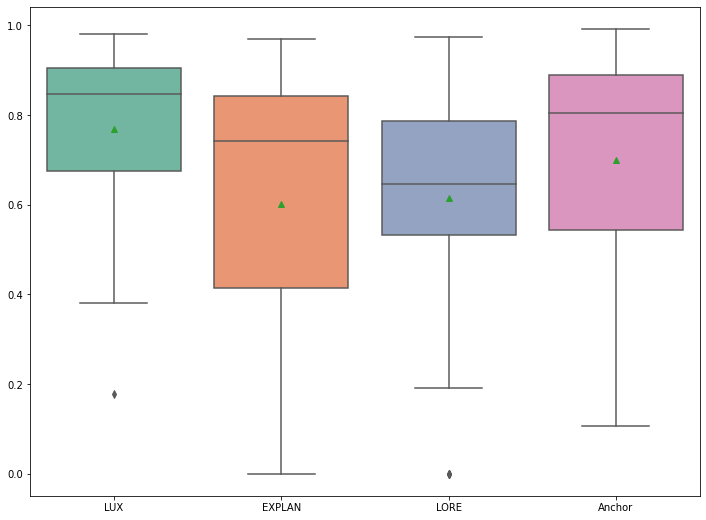

In [1443]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import f

file_paths = [f'./results/{d}/synthx100_local_fid.csv' for d in dirs]

#aggregated, aggregated_std,raw = plot_stats_comparison(file_paths,columns=['f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'])
aggregated, aggregated_std,raw_fid = plot_stats_comparison(file_paths,columns=['f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'],models=['LUX', 'EXPLAN', 'LORE', 'Anchor'],fillna=0)
aggfid=aggregated


In [1444]:
len(aggfid.index)

48

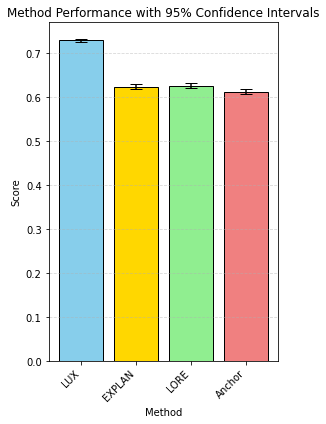

In [1445]:
method_cols = ['LUX', 'EXPLAN', 'LORE', 'Anchor']
ci_results = compute_method_confidence_intervals(raw_fid.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & 0.58 $\pm$ 0.31 & 0.52 $\pm$ 0.21 & 0.56 $\pm$ 0.26 & \textbf{0.61 $\pm$ 0.25}\\ \hline
analcatdata & 0.18 $\pm$ 0.16 & \textbf{0.21 $\pm$ 0.15} & 0.19 $\pm$ 0.16 & 0.11 $\pm$ 0.17\\ \hline
balance-scale & 0.85 $\pm$ 0.20 & 0.75 $\pm$ 0.25 & \textbf{0.88 $\pm$ 0.16} & 0.86 $\pm$ 0.17\\ \hline
banknote-authentication & 0.95 $\pm$ 0.08 & 0.90 $\pm$ 0.16 & \textbf{0.95 $\pm$ 0.07} & 0.80 $\pm$ 0.24\\ \hline
blood-transfusion-service-center & 0.77 $\pm$ 0.21 & 0.78 $\pm$ 0.22 & 0.74 $\pm$ 0.17 & \textbf{0.84 $\pm$ 0.15}\\ \hline
breast-w & 0.89 $\pm$ 0.18 & \textbf{0.95 $\pm$ 0.10} & 0.94 $\pm$ 0.05 & 0.65 $\pm$ 0.47\\ \hline
car & 0.85 $\pm$ 0.30 & 0.87 $\pm$ 0.25 & \textbf{0.93 $\pm$ 0.16} & 0.89 $\pm$ 0.26\\ \hline
churn & 0.91 $\pm$ 0.12 & \textbf{0.92 $\pm$ 0.10} & 0.87 $\pm$ 0.12 & 0.82 $\pm$ 0.31\\ \hline
clima

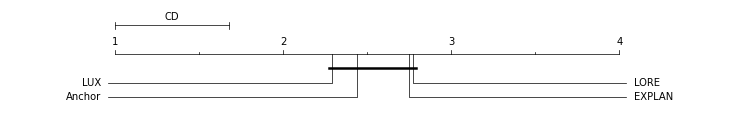

In [1446]:
print(to_latex(aggregated.astype('f8'), aggregated_std.astype('f8'), index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))

print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#aggregated.shape[1])#rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Fidelity')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])


avranks = abs(avranks -max(avranks))+min(avranks)

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_fidelity.pdf')


cd = calculate_CD(aggregated)
pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


## Simplicity

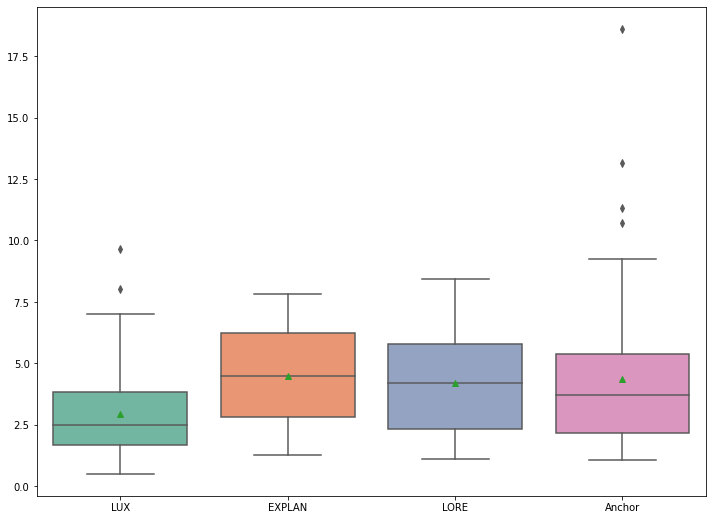

In [1447]:


file_paths = [f'./results/{d}/synthx100_rulelen.csv' for d in dirs]

aggregated, aggregated_std,raw_sim = plot_stats_comparison(file_paths, columns=['shap_lux_elen','explan_elen','lore_elen','anchor_elen'],
                                                                          models=['LUX','EXPLAN','LORE','Anchor'])
aggsim=aggregated

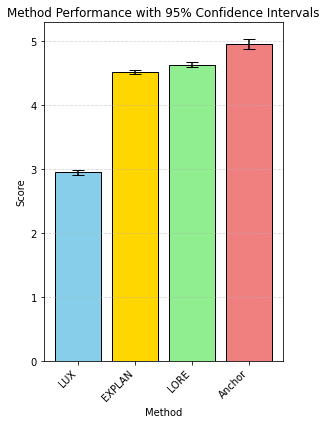

In [1448]:
method_cols = ['LUX', 'EXPLAN', 'LORE', 'Anchor']
ci_results = compute_method_confidence_intervals(raw_sim, method_columns=method_cols, plot=True, figsize=(4,6))

In [1449]:
to_latex(aggregated, aggregated_std, index_name='dataset')

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & 9.64 $\pm$ 7.19 & 6.72 $\pm$ 1.78 & 8.42 $\pm$ 2.89 & \textbf{10.71 $\pm$ 9.90}\\ \hline
analcatdata & 2.68 $\pm$ 0.73 & 3.51 $\pm$ 0.54 & 3.37 $\pm$ 0.64 & \textbf{3.85 $\pm$ 0.42}\\ \hline
balance-scale & 2.76 $\pm$ 0.73 & 2.90 $\pm$ 0.59 & \textbf{3.17 $\pm$ 0.55} & 2.22 $\pm$ 0.78\\ \hline
banknote-authentication & 1.83 $\pm$ 0.75 & 2.23 $\pm$ 0.72 & 2.35 $\pm$ 0.71 & \textbf{2.83 $\pm$ 0.87}\\ \hline
blood-transfusion-service-center & 1.84 $\pm$ 0.82 & 2.20 $\pm$ 0.78 & 2.33 $\pm$ 0.93 & \textbf{2.66 $\pm$ 1.12}\\ \hline
breast-w & 1.93 $\pm$ 0.92 & \textbf{3.19 $\pm$ 1.30} & 3.16 $\pm$ 1.34 & 2.27 $\pm$ 0.60\\ \hline
car & 2.12 $\pm$ 1.70 & 2.17 $\pm$ 1.40 & 2.20 $\pm$ 1.74 & \textbf{2.21 $\pm$ 1.97}\\ \hline
churn & 3.78 $\pm$ 2.08 & 5.17 $\pm$ 1.30 & 3.30 $\pm$ 1.53 & \textbf{5.47 $\pm$ 4.60}\\ \hline
clim

In [1450]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

66.90814196242178
1.959351717762755e-14


In [1451]:
print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')

cd = calculate_CD(aggregated)
    
pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')





Critical F-value at alpha=0.05: 2.6688
Friedman test statistic: 66.9081
Reject null-hypothesis: 2.6688 < 66.9081
Since the Friedman test statistic is greater than the critical value, we reject the null hypothesis and conclude that there are significant differences between the evaluated methods.



From the Friedman test, we obtained statistics equal to 66.91, with p-value equal to $1.96 \times 10^{-14}$ which was greater then F-value equal to 2.6688 and allowed us to reject the null hypothesis.
With 4 algorithms and 48 datasets, we had 3 x 141 degrees of freedom, respectively.
This allowed us to determine that the critical value for $F( 3 , 141 )$ for $\alpha=0.05$ is 0.6769909424143805.


In [1452]:

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

,LUX,EXPLAN,LORE,Anchor
LUX,1.000,0.001000,0.001000,0.001000
EXPLAN,0.001,1.000000,0.229237,0.061465
LORE,0.001,0.229237,1.000000,0.900000
Anchor,0.001,0.061465,0.900000,1.000000


In [1453]:
avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),aggregated.shape[1])#rankdata(aggregated, axis=1)#rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Simplicity')
avinv = abs(avranks -max(avranks))+min(avranks)
lux.append(avinv[0])
explan.append(avinv[1])
lore.append(avinv[2])
anchor.append(avinv[3])

cd=0.6769993751548077


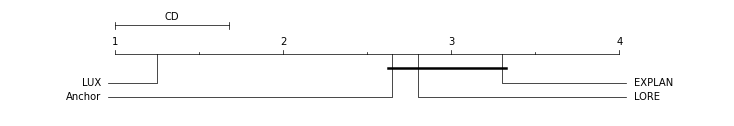

In [1454]:
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_simplicity.pdf')

In [1455]:
avranks

array([1.25      , 3.30208333, 2.80208333, 2.64583333])

## Counterfactuals

In [1456]:
pd.read_csv(f'./results/ablation-full-knn/synthx100_scores.csv',on_bad_lines='skip')

,dataset,num_and_cat,model_score,instance_certainty_clf,dectree_score,ac_score_ablation,ac_score_pure,ac_score_proba,ac_score_shap,ac_score_explan,...,rec_score_shap,rec_score_explan,rec_score_lore,dectree_score_f1,f1_score_ablation,f1_score_pure,f1_score_proba,f1_score_shap,f1_score_explan,f1_score_lore
0,kr-vs-kp,./data/num_and_cat/balanced,0.928661,1.0,0.962025,0.924051,0,0,0.911392,0.658228,...,0.888889,0.925926,0.518519,0.971963,0.942308,0,0,0.932039,0.787402,0.682927
1,kr-vs-kp,./data/num_and_cat/balanced,0.928661,0.6,0.911392,0.746835,0,0,0.000000,0.367089,...,0.000000,0.900000,0.266667,0.885246,0.666667,0,0,0.000000,0.519231,0.400000
2,balance-scale,./data/num_and_cat/balanced,0.821656,0.4,0.466667,0.733333,0,0,0.666667,0.533333,...,0.666667,0.533333,0.733333,0.466667,0.733333,0,0,0.666667,0.533333,0.733333
3,balance-scale,./data/num_and_cat/balanced,0.821656,0.6,0.800000,0.733333,0,0,0.800000,0.866667,...,0.800000,0.866667,0.800000,0.800000,0.733333,0,0,0.800000,0.866667,0.800000
4,breast-w,./data/num_and_cat/balanced,0.953216,1.0,1.000000,1.000000,0,0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14370,cylinder-bands,./data/num_and_cat/balanced,0.785714,0.8,0.428571,0.571429,0,0,0.571429,0.857143,...,0.600000,1.000000,0.200000,0.500000,0.666667,0,0,0.666667,0.909091,0.285714
14371,cylinder-bands,./data/num_and_cat/balanced,0.785714,0.6,0.714286,0.857143,0,0,0.571429,0.714286,...,0.666667,0.666667,0.333333,0.666667,0.800000,0,0,0.571429,0.666667,0.400000
14372,cylinder-bands,./data/num_and_cat/balanced,0.785714,1.0,0.571429,0.571429,0,0,0.714286,0.428571,...,1.000000,0.400000,1.000000,0.727273,0.727273,0,0,0.833333,0.500000,0.833333
14373,cylinder-bands,./data/num_and_cat/balanced,0.785714,0.8,0.857143,0.857143,0,0,0.857143,0.857143,...,0.857143,0.857143,0.857143,0.923077,0.923077,0,0,0.923077,0.923077,0.923077


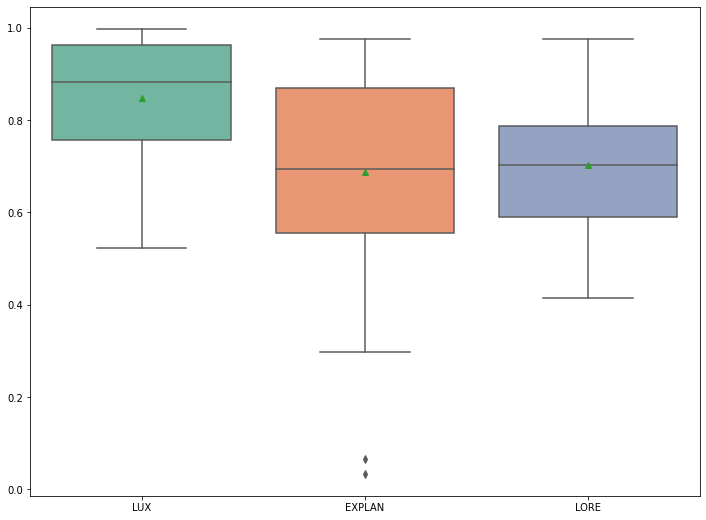

In [1457]:


file_paths = [f'./results/{d}/synthx100_scores.csv' for d in dirs]


aggregated, aggregated_std,raw_cf = plot_stats_comparison(file_paths, columns=['f1_score_shap','f1_score_explan','f1_score_lore'], models=['LUX','EXPLAN','LORE'],invalid=0,fillna=0)
aggcf=aggregated

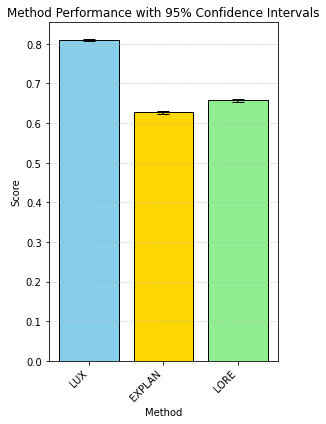

In [1458]:
method_cols = ['LUX', 'EXPLAN', 'LORE']
ci_results = compute_method_confidence_intervals(raw_cf.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE
\\ \hline \hline
GesturePhaseSegmentationProcessed & \textbf{0.70 $\pm$ 0.14} & 0.51 $\pm$ 0.17 & 0.53 $\pm$ 0.23\\ \hline
analcatdata & \textbf{0.63 $\pm$ 0.23} & 0.53 $\pm$ 0.18 & 0.54 $\pm$ 0.16\\ \hline
balance-scale & \textbf{0.78 $\pm$ 0.13} & 0.67 $\pm$ 0.16 & 0.77 $\pm$ 0.13\\ \hline
banknote-authentication & \textbf{1.00 $\pm$ 0.01} & 0.94 $\pm$ 0.11 & 0.97 $\pm$ 0.07\\ \hline
blood-transfusion-service-center & \textbf{0.91 $\pm$ 0.17} & 0.87 $\pm$ 0.18 & 0.84 $\pm$ 0.17\\ \hline
breast-w & \textbf{0.98 $\pm$ 0.04} & 0.97 $\pm$ 0.07 & 0.97 $\pm$ 0.05\\ \hline
car & 0.83 $\pm$ 0.27 & 0.86 $\pm$ 0.11 & \textbf{0.88 $\pm$ 0.09}\\ \hline
churn & \textbf{0.96 $\pm$ 0.08} & 0.88 $\pm$ 0.15 & 0.91 $\pm$ 0.13\\ \hline
climate-model-simulation-crashes & \textbf{0.96 $\pm$ 0.08} & 0.91 $\pm$ 0.09 & 0.53 $\pm$ 0.10\\ \hline
cmc & 0.52 $\pm$ 0.28 & \textbf{0.61 $\pm$ 0.10} & 0.59

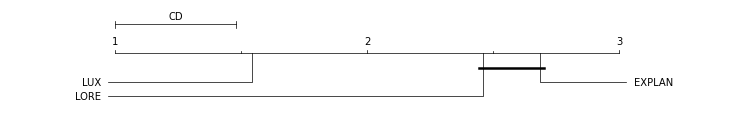

In [1459]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')



nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Counterfactual Fidelity')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(0)

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_counterfactuals.pdf')
cd = calculate_CD(aggregated)
    
pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


## Coverage

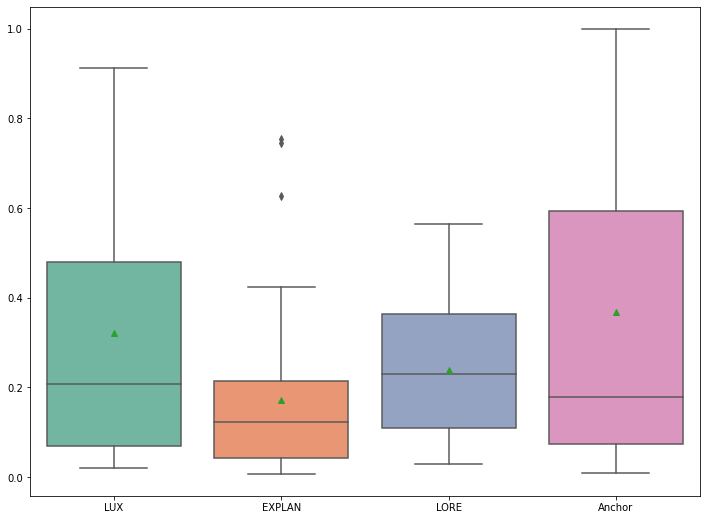

In [1460]:


file_paths = [ f'./results/{d}/synthx100_rulecov.csv' for d in dirs]




aggregated, aggregated_std,raw_cov = plot_stats_comparison(file_paths, columns=['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor'], invalid=0,fillna=0)#, models=['LUX','EXPLAN','LORE'])



aggcov=aggregated

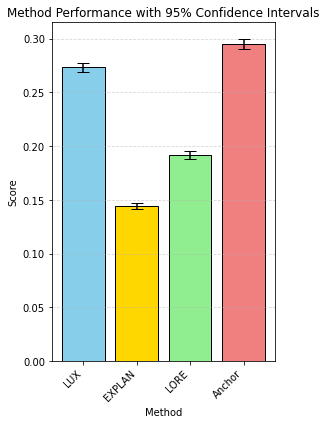

In [1461]:
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_cov.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & 0.02 $\pm$ 0.04 & 0.03 $\pm$ 0.04 & \textbf{0.08 $\pm$ 0.10} & 0.05 $\pm$ 0.07\\ \hline
analcatdata & 0.06 $\pm$ 0.07 & 0.06 $\pm$ 0.03 & 0.05 $\pm$ 0.04 & \textbf{0.08 $\pm$ 0.10}\\ \hline
balance-scale & 0.13 $\pm$ 0.08 & 0.14 $\pm$ 0.07 & \textbf{0.15 $\pm$ 0.08} & 0.10 $\pm$ 0.08\\ \hline
banknote-authentication & 0.25 $\pm$ 0.13 & 0.21 $\pm$ 0.16 & 0.25 $\pm$ 0.11 & \textbf{0.44 $\pm$ 0.44}\\ \hline
blood-transfusion-service-center & 0.28 $\pm$ 0.19 & 0.25 $\pm$ 0.16 & \textbf{0.36 $\pm$ 0.21} & 0.24 $\pm$ 0.19\\ \hline
breast-w & \textbf{0.47 $\pm$ 0.22} & 0.40 $\pm$ 0.24 & 0.47 $\pm$ 0.22 & 0.18 $\pm$ 0.17\\ \hline
car & 0.22 $\pm$ 0.14 & 0.21 $\pm$ 0.14 & \textbf{0.25 $\pm$ 0.13} & 0.24 $\pm$ 0.15\\ \hline
churn & 0.22 $\pm$ 0.25 & 0.28 $\pm$ 0.27 & \textbf{0.56 $\pm$ 0.31} & 0.14 $\pm$ 0.15\\ \hline
clima

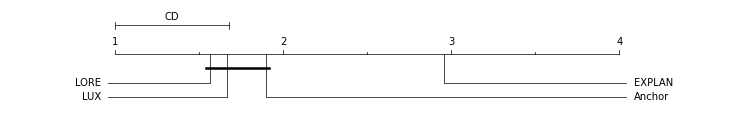

In [1462]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),4)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks
print(avranks)
if x:
    subjects.append('Coverage')
    lux.append(avranks[0])
    explan.append(avranks[1])
    lore.append(avranks[2])
    anchor.append(avranks[3])
avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_coverage.pdf')

cd = calculate_CD(aggregated)
    
pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


In [1463]:
aggregated.head()

,LUX,EXPLAN,LORE,Anchor
dataset,,,,
GesturePhaseSegmentationProcessed,0.019429,0.031029,0.078716,0.049939
analcatdata,0.061926,0.058587,0.049691,0.078905
balance-scale,0.132418,0.136588,0.147890,0.104201
banknote-authentication,0.247297,0.213706,0.253940,0.435591
blood-transfusion-service-center,0.284774,0.246107,0.362990,0.235294


In [1464]:
np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),4).mean(axis=0)

array([2.85416667, 1.5625    , 2.95833333, 2.625     ])

## Stability

### instance-based

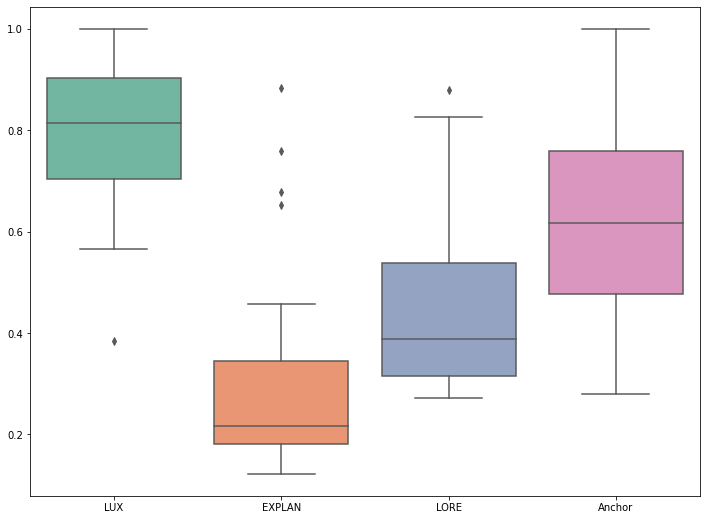

In [1465]:
#results_stab_data = pd.read_csv("./results/stability-multids-4-20x10-os-fp-nf-2.csv").fillna(0)

results_stab_data1 = pd.read_csv("./results/stability-multids-4-20x10-os-novel-shap-no-density.csv").dropna()
results_stab_data2 = pd.read_csv("./results/stability-multids-20-50x10-os-novel-shap-no-density.csv").dropna()

results_stab_data = pd.concat((results_stab_data1,results_stab_data2))

instacne_stats_features = [f for f in results_stab_data if 'instance_mean' in f]
instance_consistency_data = results_stab_data[['num_and_cat']+instacne_stats_features].copy()

instance_consistency_data.columns=['Dataset','EXPLAN','LORE','Anchor','LUX']
forder = ['Dataset', 'LUX','EXPLAN','LORE','Anchor']
aggregated = instance_consistency_data[forder].set_index('Dataset')


fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/consistency_instance-comp.pdf', format='pdf',bbox_inches='tight')
plt.show()


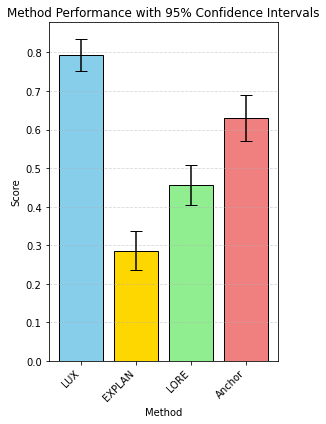

In [1466]:
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(instance_consistency_data.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
Dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
4 & 0.68 & 0.65 & 0.81 & 1.00\\ \hline
5 & 0.60 & 0.88 & 0.76 & 0.53\\ \hline
6 & 0.99 & 0.76 & 0.88 & 0.75\\ \hline
7 & 1.00 & 0.68 & 0.69 & 1.00\\ \hline
8 & 0.87 & 0.39 & 0.81 & 1.00\\ \hline
9 & 0.95 & 0.46 & 0.53 & 0.77\\ \hline
10 & 0.57 & 0.35 & 0.66 & 1.00\\ \hline
11 & 0.76 & 0.31 & 0.54 & 0.57\\ \hline
12 & 0.77 & 0.40 & 0.78 & 0.44\\ \hline
13 & 0.70 & 0.38 & 0.83 & 0.94\\ \hline
14 & 0.81 & 0.33 & 0.53 & 0.50\\ \hline
15 & 0.90 & 0.25 & 0.53 & 0.76\\ \hline
16 & 0.75 & 0.33 & 0.53 & 0.67\\ \hline
17 & 0.79 & 0.37 & 0.57 & 0.94\\ \hline
18 & 0.75 & 0.37 & 0.60 & 0.91\\ \hline
19 & 0.83 & 0.39 & 0.56 & 0.74\\ \hline
20 & 0.85 & 0.27 & 0.45 & 0.68\\ \hline
21 & 0.69 & 0.24 & 0.49 & 0.73\\ \hline
22 & 0.72 & 0.27 & 0.38 & 0.82\\ \hline
23 & 0.90 & 0.22 & 0.44 & 0.60\\ \hline
24 & 0.59 & 0.22 & 0.35 & 0.69\\ \hline
25 & 0.82 & 0.21 & 0.38 & 0.60\\ 

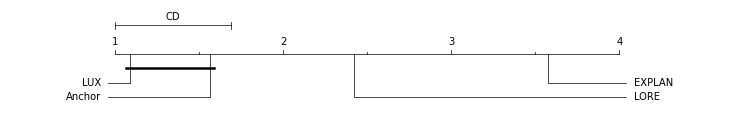

In [1467]:
print(to_latex_nostd(aggregated, index_name='Dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

# subjects.append('Stability')
# lux.append(avranks[0])
# explan.append(avranks[1])
# lore.append(avranks[2])
# anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_consistency.pdf')

cd = calculate_CD(aggregated)
    
pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


### Feature-based

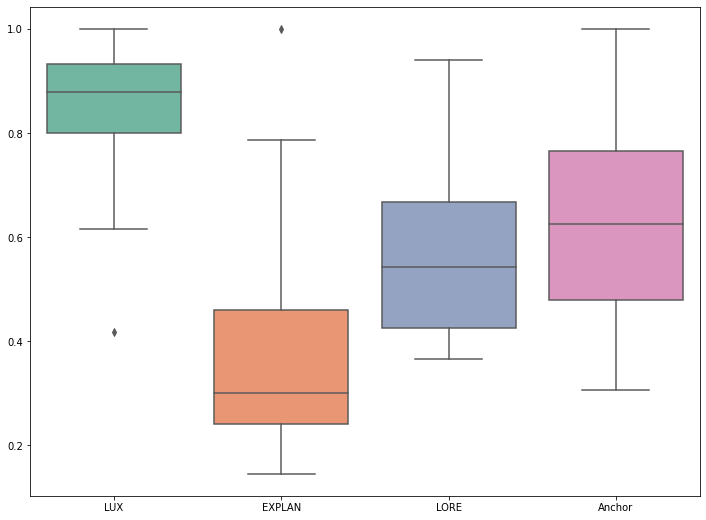

In [1468]:
#results_stab_data = pd.read_csv("./results/stability-multids-4-20x10-os-fp-nf-2.csv").dropna()
results_stab_data1 = pd.read_csv("./results/stability-multids-4-20x10-os-novel-shap-no-density.csv").dropna()
results_stab_data2 = pd.read_csv("./results/stability-multids-20-50x10-os-novel-shap-no-density.csv").dropna()
results_stab_data = pd.concat((results_stab_data1,results_stab_data2))

instacne_stats_features = [f for f in results_stab_data if 'feature_mean' in f]
instance_consistency_data = results_stab_data[['num_and_cat']+instacne_stats_features].copy()

instance_consistency_data.columns=['Dataset','EXPLAN','LORE','Anchor','LUX']
forder = ['Dataset', 'LUX','EXPLAN','LORE','Anchor']
aggregated = instance_consistency_data[forder].set_index('Dataset')


fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/consistency_feature-comp.pdf', format='pdf',bbox_inches='tight')
plt.show()

aggstab=aggregated

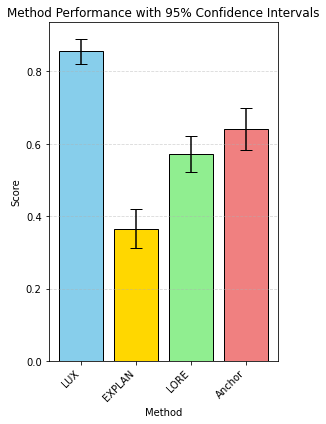

In [1469]:
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(instance_consistency_data.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
Dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
4 & 0.79 & 0.76 & 0.84 & 1.00\\ \hline
5 & 0.75 & 1.00 & 0.79 & 0.65\\ \hline
6 & 1.00 & 0.79 & 0.91 & 0.75\\ \hline
7 & 1.00 & 0.71 & 0.76 & 1.00\\ \hline
8 & 1.00 & 0.49 & 0.94 & 1.00\\ \hline
9 & 0.95 & 0.52 & 0.63 & 0.77\\ \hline
10 & 0.62 & 0.48 & 0.76 & 1.00\\ \hline
11 & 0.84 & 0.52 & 0.79 & 0.58\\ \hline
12 & 0.89 & 0.54 & 0.88 & 0.48\\ \hline
13 & 0.80 & 0.46 & 0.87 & 0.94\\ \hline
14 & 0.81 & 0.44 & 0.67 & 0.50\\ \hline
15 & 0.91 & 0.31 & 0.62 & 0.76\\ \hline
16 & 0.83 & 0.39 & 0.63 & 0.67\\ \hline
17 & 0.80 & 0.52 & 0.66 & 0.94\\ \hline
18 & 0.86 & 0.45 & 0.69 & 0.91\\ \hline
19 & 0.95 & 0.54 & 0.69 & 0.80\\ \hline
20 & 0.89 & 0.40 & 0.55 & 0.68\\ \hline
21 & 0.80 & 0.32 & 0.62 & 0.76\\ \hline
22 & 0.74 & 0.36 & 0.60 & 0.82\\ \hline
23 & 0.93 & 0.30 & 0.54 & 0.60\\ \hline
24 & 0.71 & 0.31 & 0.50 & 0.69\\ \hline
25 & 0.83 & 0.30 & 0.55 & 0.60\\ 

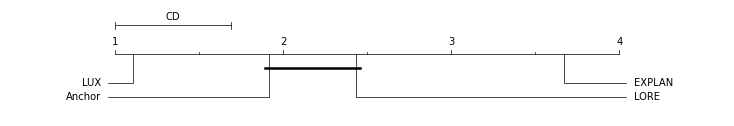

In [1470]:
print(to_latex_nostd(aggregated, index_name='Dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Stability')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_consistency.pdf')

cd = calculate_CD(aggregated)
    
pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


## Counterfactual representativeness (Phantom branches)

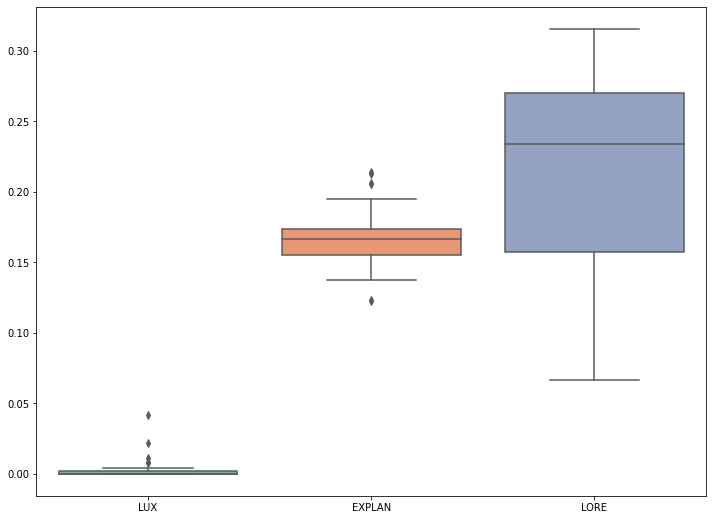

In [1471]:

fig, ax = plt.subplots(figsize=(12,9))
raw_pb = pd.read_csv('./results/phantoms-both-novel-shap-no-density-latest.csv').dropna()[['dimensionality','phantom_ratio_lux','phantom_ratio_explan', 'phantom_ratio_lore']]
raw_pb.columns=['Dataset','LUX','EXPLAN','LORE']
aggregated = pd.read_csv('./results/phantoms-both-novel-shap-no-density-latest.csv').dropna().groupby('dimensionality')[['phantom_ratio_lux','phantom_ratio_explan', 'phantom_ratio_lore']].mean()
aggregated.columns=['LUX','EXPLAN','LORE']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/representativeness-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv('./results/phantoms-both-last.csv').dropna().groupby('dimensionality')[[ 'phantom_ratio_lux','phantom_ratio_explan', 'phantom_ratio_lore']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE']
aggphantom=aggregated

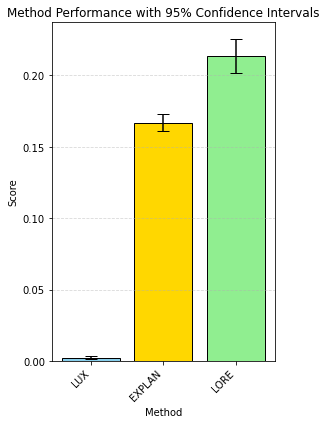

In [1472]:
method_cols = ['LUX', 'EXPLAN', 'LORE']
ci_results = compute_method_confidence_intervals(raw_pb.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|}
\hline
Dataset size & LUX&EXPLAN&LORE
\\ \hline \hline
4 & 0.04 & 0.15 & 0.10\\ \hline
5 & 0.01 & 0.16 & 0.07\\ \hline
6 & 0.00 & 0.21 & 0.07\\ \hline
7 & 0.00 & 0.15 & 0.11\\ \hline
8 & 0.00 & 0.18 & 0.12\\ \hline
9 & 0.02 & 0.21 & 0.10\\ \hline
10 & 0.01 & 0.17 & 0.26\\ \hline
11 & 0.01 & 0.19 & 0.15\\ \hline
12 & 0.00 & 0.17 & 0.18\\ \hline
13 & 0.00 & 0.18 & 0.14\\ \hline
14 & 0.00 & 0.12 & 0.17\\ \hline
15 & 0.00 & 0.15 & 0.15\\ \hline
16 & 0.00 & 0.14 & 0.21\\ \hline
17 & 0.00 & 0.21 & 0.15\\ \hline
18 & 0.00 & 0.19 & 0.14\\ \hline
19 & 0.00 & 0.15 & 0.17\\ \hline
20 & 0.00 & 0.17 & 0.24\\ \hline
21 & 0.00 & 0.17 & 0.14\\ \hline
22 & 0.00 & 0.17 & 0.24\\ \hline
23 & 0.00 & 0.19 & 0.22\\ \hline
24 & 0.00 & 0.16 & 0.24\\ \hline
25 & 0.00 & 0.16 & 0.23\\ \hline
26 & 0.00 & 0.16 & 0.18\\ \hline
27 & 0.00 & 0.17 & 0.25\\ \hline
28 & 0.00 & 0.17 & 0.24\\ \hline
29 & 0.00 & 0.16 & 0.28\\ \hline
30 & 0.00 & 0.14 & 

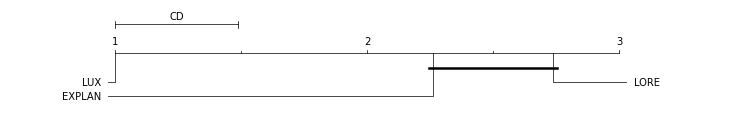

In [1473]:
print(to_latex_nostd(aggregated, index_name='Dataset size'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

avinv = abs(avranks -max(avranks))+min(avranks)
subjects.append('Representativeness')
lux.append(avinv[0])
explan.append(avinv[1])
lore.append(avinv[2])
anchor.append(0)

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_representativeness.pdf')

cd = calculate_CD(aggregated)

pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


## Shap-consistency

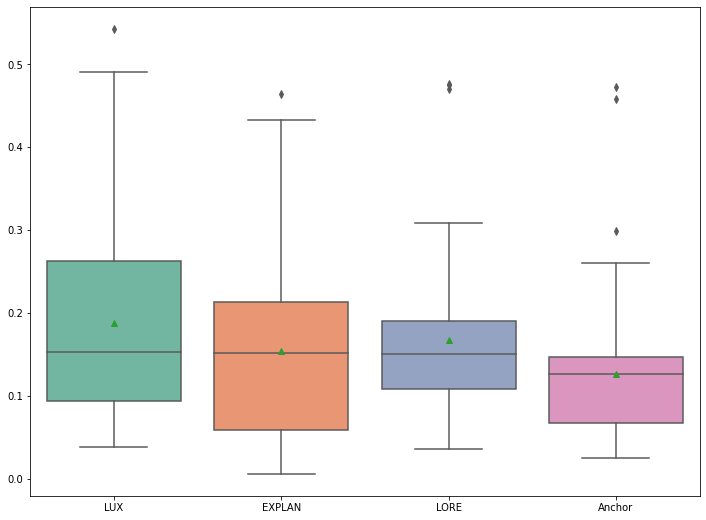

In [1474]:

file_paths = [f'./results/{d}/synthx100_importance_gain.csv' for d in dirs]

aggregated, aggregated_std,raw_shap = plot_stats_comparison(file_paths, columns=['importance_gain_shap','importance_gain_explan','importance_gain_lore','importance_gain_anchor'], models=['LUX','EXPLAN','LORE','Anchor'],invalid=0,fillna=0)
aggconsist_shap = aggregated

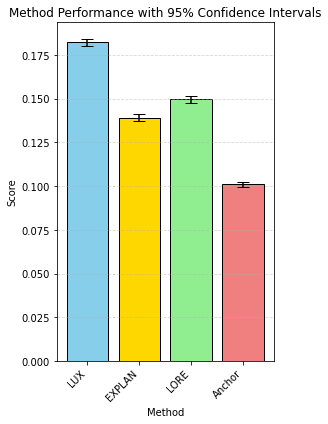

In [1475]:
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_shap.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

In [1476]:
aggregated.mean()

LUX       0.187165
EXPLAN    0.154082
LORE      0.166973
Anchor    0.126006
dtype: float64

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & 0.04 $\pm$ 0.03 & \textbf{0.05 $\pm$ 0.02} & 0.05 $\pm$ 0.02 & 0.04 $\pm$ 0.02\\ \hline
analcatdata & \textbf{0.35 $\pm$ 0.09} & 0.27 $\pm$ 0.05 & 0.26 $\pm$ 0.07 & 0.22 $\pm$ 0.05\\ \hline
balance-scale & 0.26 $\pm$ 0.06 & 0.26 $\pm$ 0.05 & 0.27 $\pm$ 0.04 & \textbf{0.30 $\pm$ 0.09}\\ \hline
banknote-authentication & \textbf{0.34 $\pm$ 0.17} & 0.32 $\pm$ 0.13 & 0.31 $\pm$ 0.13 & 0.16 $\pm$ 0.15\\ \hline
blood-transfusion-service-center & \textbf{0.32 $\pm$ 0.16} & 0.29 $\pm$ 0.12 & 0.29 $\pm$ 0.14 & 0.26 $\pm$ 0.12\\ \hline
breast-w & 0.09 $\pm$ 0.09 & \textbf{0.15 $\pm$ 0.09} & 0.11 $\pm$ 0.08 & 0.14 $\pm$ 0.11\\ \hline
car & 0.39 $\pm$ 0.26 & 0.43 $\pm$ 0.24 & 0.47 $\pm$ 0.24 & \textbf{0.47 $\pm$ 0.25}\\ \hline
churn & 0.13 $\pm$ 0.08 & 0.10 $\pm$ 0.05 & \textbf{0.14 $\pm$ 0.11} & 0.07 $\pm$ 0.05\\ \hline
clima

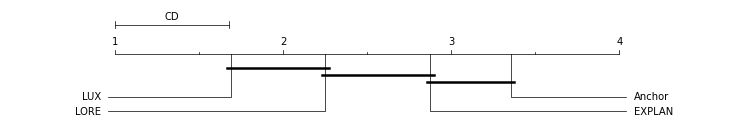

In [1477]:
#print(to_latex_nostd(aggregated, index_name='Dataset size'))
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('SHAP Consistency')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_shapconsistency.pdf')

cd = calculate_CD(aggregated)
    
pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


## Hits

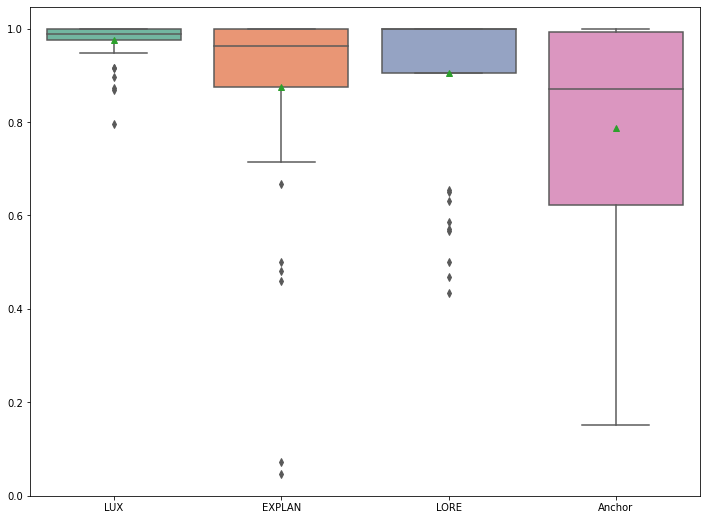

In [1480]:
file_paths = [ f'./results/{d}/synthx100_hits.csv' for d in dirs]




aggregated, aggregated_std,raw_hits = plot_stats_comparison(file_paths, columns=['hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'],invalid=0,fillna=0)#, models=['LUX','EXPLAN','LORE'])

agghits = aggregated

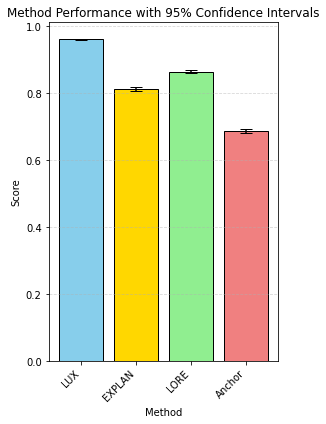

In [1481]:
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_hits.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

In [1482]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & \textbf{1.00 $\pm$ 0.00} & \textbf{1.00 $\pm$ 0.00} & \textbf{1.00 $\pm$ 0.00} & 0.96 $\pm$ 0.20\\ \hline
analcatdata & 0.96 $\pm$ 0.19 & 0.85 $\pm$ 0.36 & \textbf{1.00 $\pm$ 0.00} & 0.32 $\pm$ 0.47\\ \hline
balance-scale & 0.98 $\pm$ 0.13 & 0.86 $\pm$ 0.35 & \textbf{1.00 $\pm$ 0.00} & 0.58 $\pm$ 0.49\\ \hline
banknote-authentication & \textbf{1.00 $\pm$ 0.00} & 0.99 $\pm$ 0.11 & \textbf{1.00 $\pm$ 0.00} & \textbf{1.00 $\pm$ 0.00}\\ \hline
blood-transfusion-service-center & \textbf{0.99 $\pm$ 0.10} & 0.95 $\pm$ 0.23 & 0.95 $\pm$ 0.22 & 0.88 $\pm$ 0.32\\ \hline
breast-w & \textbf{1.00 $\pm$ 0.00} & \textbf{1.00 $\pm$ 0.00} & \textbf{1.00 $\pm$ 0.00} & 0.61 $\pm$ 0.49\\ \hline
car & 0.92 $\pm$ 0.28 & \textbf{1.00 $\pm$ 0.00} & \textbf{1.00 $\pm$ 0.00} & 0.84 $\pm$ 0.37\\ \hline
churn & \textbf{1.00 $\pm$ 0.00} & \te




Critical F-value at alpha=0.05: 2.6688
Friedman test statistic: 25.3406
Reject null-hypothesis: 2.6688 < 25.3406
Since the Friedman test statistic is greater than the critical value, we reject the null hypothesis and conclude that there are significant differences between the evaluated methods.
cd=0.6769993751548077



From the Friedman test, we obtained statistics equal to 25.34, with p-value equal to $1.31 \times 10^{-5}$ which was greater then F-value equal to 2.6688 and allowed us to reject the null hypothesis.
With 4 algorithms and 48 datasets, we had 3 x 141 degrees of freedom, respectively.
This allowed us to determine that the critical value for $F( 3 , 141 )$ for $\alpha=0.05$ is 0.6769909424143805.


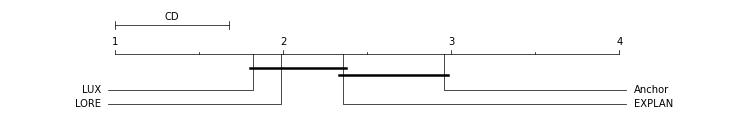

In [1483]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
print('\n\n')
print(f'Critical F-value at alpha=0.05: {ppf:.4f}')
print(f'Friedman test statistic: {result[0]:.4f}')

if ppf < result[0]:
    print(f'Reject null-hypothesis: {ppf:.4f} < {result[0]:.4f}')
    print('Since the Friedman test statistic is greater than the critical value, '
          'we reject the null hypothesis and conclude that there are significant differences '
          'between the evaluated methods.')
else:
    print(f'Do not reject null-hypothesis: {ppf:.4f} >= {result[0]:.4f}')
    print('Since the Friedman test statistic does not exceed the critical value, '
          'we cannot reject the null hypothesis. This means that there is no statistically significant '
          'difference in performance among the methods.')

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks
if x:
    subjects.append('Hits')
    lux.append(avranks[0])
    explan.append(avranks[1])
    lore.append(avranks[2])
    anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_hits_real.pdf')

cd = calculate_CD(aggregated)
    
pval = result.pvalue

if pval < 1e-4:
    exponent = int(math.floor(math.log10(pval)))
    base = pval / 10**exponent
    pval_str = f"${base:.2f} \\times 10^{{{exponent}}}$"
else:
    pval_str = f"${pval:.4f}$"
    
print('\n\n')
# Print the final statistics
print(f'From the Friedman test, we obtained statistics equal to {result.statistic:.2f}, with p-value equal to {pval_str} which was greater then F-value equal to {ppf:.4f} and allowed us to reject the null hypothesis.') 
print(f'With {aggregated.shape[1]} algorithms and {aggregated.shape[0]} datasets, we had {aggregated.shape[1] - 1} x {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} degrees of freedom, respectively.')
print(f'This allowed us to determine that the critical value for $F( {aggregated.shape[1] - 1} , {(aggregated.shape[0] - 1) * (aggregated.shape[1] - 1)} )$ for $\\alpha=0.05$ is {cd}.')


## Confidence intervals

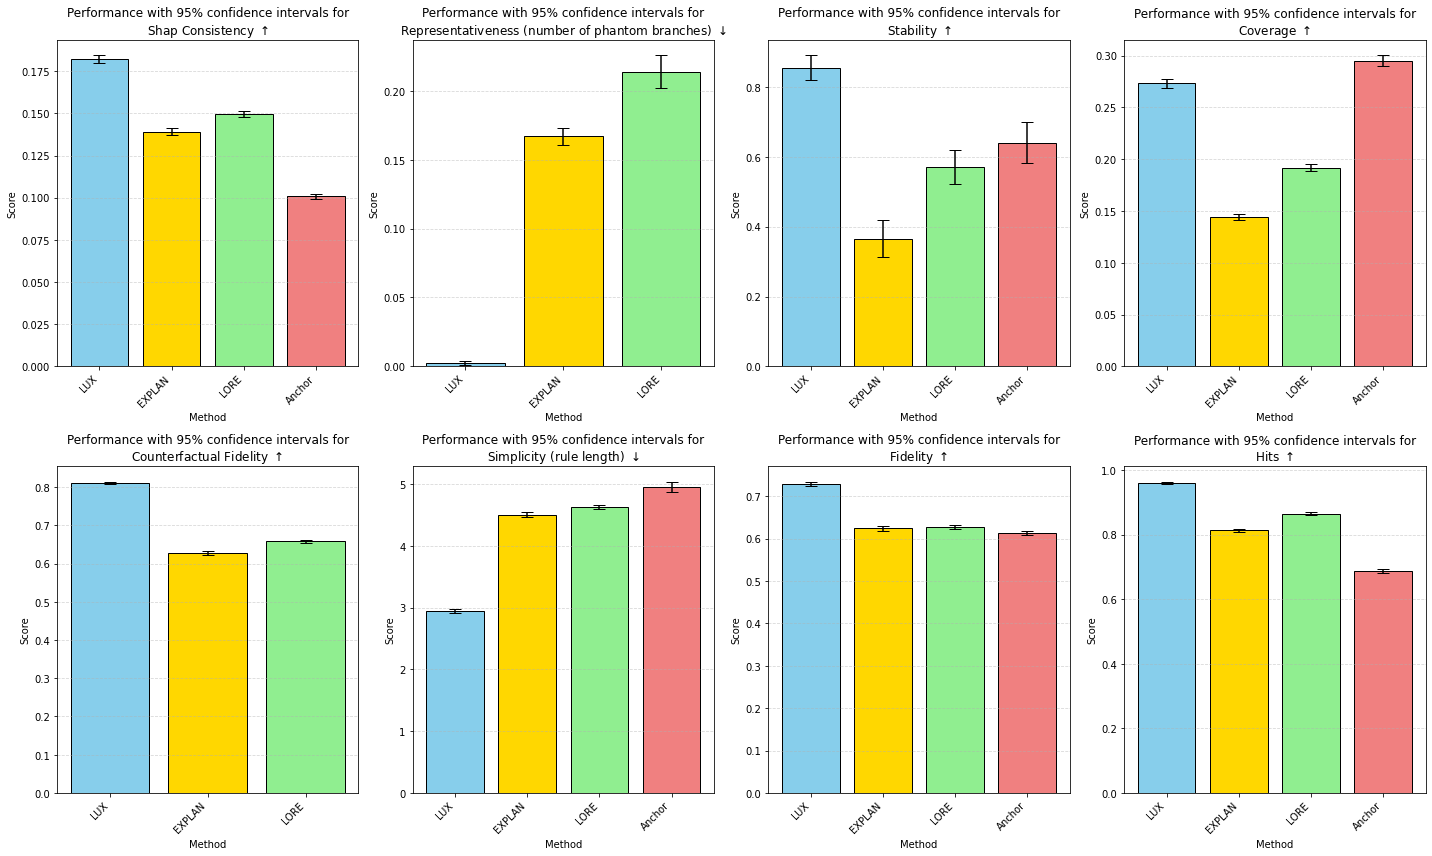

In [1484]:
fig, axs = plt.subplots(2,4, figsize=(20,12))
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_shap.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,0],
                                            title="Performance with 95% confidence intervals for\nShap Consistency $\\uparrow$")
method_cols = ['LUX', 'EXPLAN', 'LORE']
ci_results = compute_method_confidence_intervals(raw_pb.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,1],
                                                 title='Performance with 95% confidence intervals for\nRepresentativeness (number of phantom branches) $\\downarrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(instance_consistency_data.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,2],
                                                 title='Performance with 95% confidence intervals for\nStability $\\uparrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_cov.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,3],
                                                 title='Performance with 95% confidence intervals for\nCoverage $\\uparrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE']
ci_results = compute_method_confidence_intervals(raw_cf.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,0],
                                                 title='Performance with 95% confidence intervals for\nCounterfactual Fidelity $\\uparrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE', 'Anchor']
ci_results = compute_method_confidence_intervals(raw_sim, method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,1],
                                                 title='Performance with 95% confidence intervals for\nSimplicity (rule length) $\\downarrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE', 'Anchor']
ci_results = compute_method_confidence_intervals(raw_fid.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,2],
                                                 title='Performance with 95% confidence intervals for\nFidelity $\\uparrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_hits.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,3],
                                                 title='Performance with 95% confidence intervals for\nHits $\\uparrow$')
plt.tight_layout()

plt.savefig('./pix/average-performance.pdf', format='pdf',bbox_inches='tight')

# Confidence intervals fper method
We exclude tests that were performed on synth datasets.

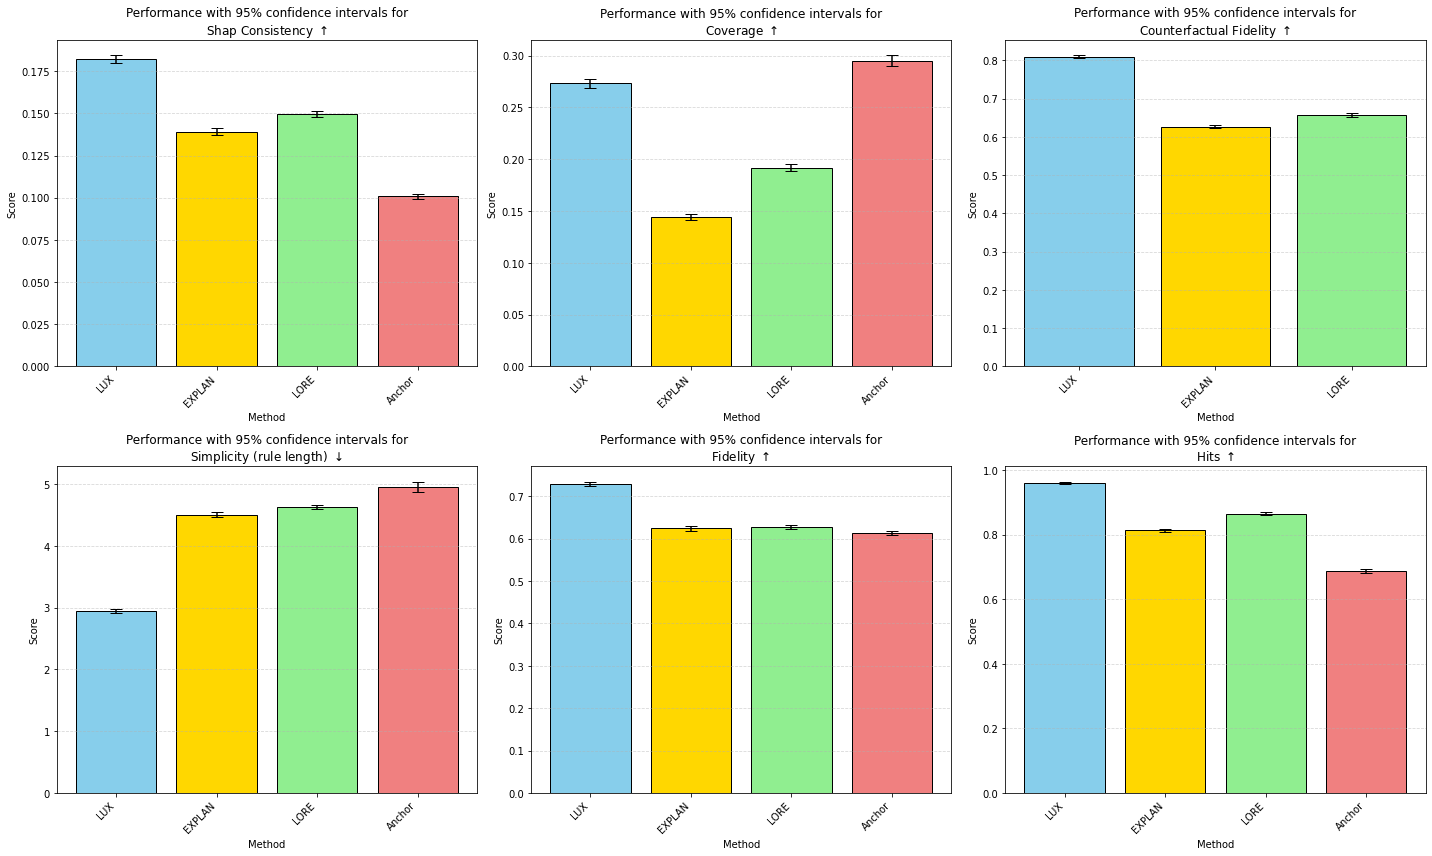

In [1485]:
fig, axs = plt.subplots(2,3, figsize=(20,12))
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_shap.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,0],
                                            title="Performance with 95% confidence intervals for\nShap Consistency $\\uparrow$")
#method_cols = ['LUX', 'EXPLAN', 'LORE']
#ci_results = compute_method_confidence_intervals(raw_pb.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,1],
#                                                 title='Performance with 95% confidence intervals for\nRepresentativeness (number of phantom branches) $\\downarrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
#ci_results = compute_method_confidence_intervals(instance_consistency_data.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,2],
#                                                 title='Performance with 95% confidence intervals for\nStability $\\uparrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_cov.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,1],
                                                 title='Performance with 95% confidence intervals for\nCoverage $\\uparrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE']
ci_results = compute_method_confidence_intervals(raw_cf.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,2],
                                                 title='Performance with 95% confidence intervals for\nCounterfactual Fidelity $\\uparrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE', 'Anchor']
ci_results = compute_method_confidence_intervals(raw_sim, method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,0],
                                                 title='Performance with 95% confidence intervals for\nSimplicity (rule length) $\\downarrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE', 'Anchor']
ci_results = compute_method_confidence_intervals(raw_fid.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,1],
                                                 title='Performance with 95% confidence intervals for\nFidelity $\\uparrow$')
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor']
ci_results = compute_method_confidence_intervals(raw_hits.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,2],
                                                 title='Performance with 95% confidence intervals for\nHits $\\uparrow$')
plt.tight_layout()

plt.savefig('./pix/average-performance-mlp.pdf', format='pdf',bbox_inches='tight')

## Times

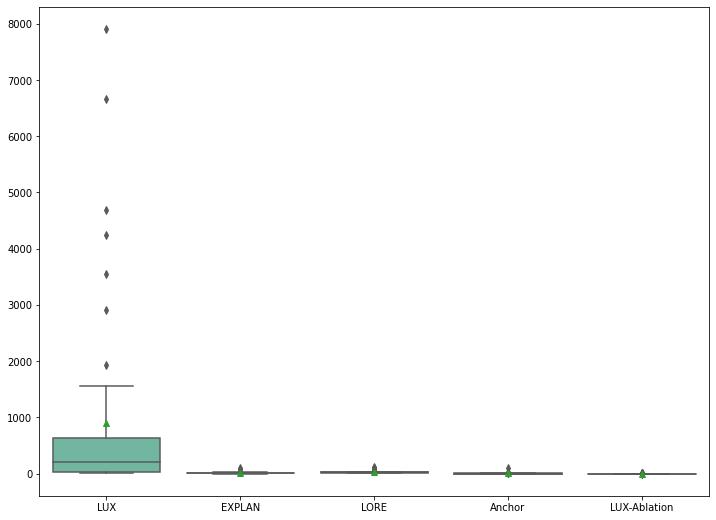

In [1486]:
file_paths = [ f'./results/{d}/synthx100_times.csv' for d in dirs]




aggregated, aggregated_std,raw_times = plot_stats_comparison(file_paths, columns=['time_lux_shap','time_explan','time_lore','time_anchor', 'time_lux_ablation'],
                                                             invalid=0,fillna=None, models=['LUX','EXPLAN','LORE','Anchor','LUX-Ablation'])

aggtime = aggregated

In [1487]:
raw_times

,dataset,LUX,EXPLAN,LORE,Anchor,LUX-Ablation
0,kr-vs-kp,231.048548,10.519569,5.877709,1.042570,0.871425
1,kr-vs-kp,326.793399,6.632184,6.247015,1.687448,0.904048
2,kr-vs-kp,179.773129,1.792554,5.295847,0.670669,0.632234
3,kr-vs-kp,176.537922,4.080447,4.939048,0.615071,0.619906
4,kr-vs-kp,210.223565,8.307765,6.748936,1.388391,0.716730
...,...,...,...,...,...,...
2758,volcanoes-e5,17.168063,NaN,5.460665,0.061279,0.048340
2759,volcanoes-e5,17.690112,NaN,5.423775,0.059386,0.050166
2760,volcanoes-e5,12.759959,NaN,5.548307,0.075700,0.049622
2761,volcanoes-e5,16.032673,NaN,NaN,0.064769,0.057570


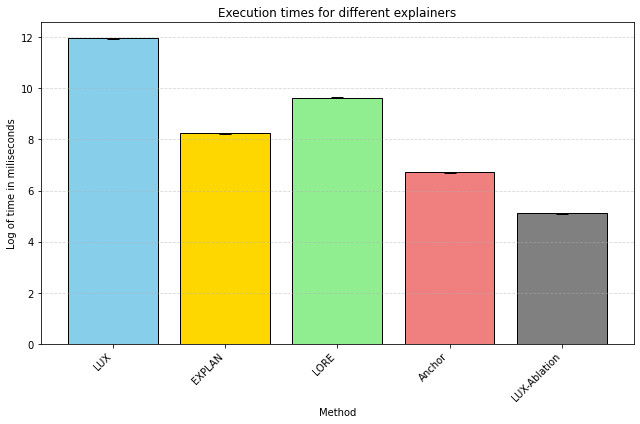

In [1488]:
method_cols = ['LUX', 'EXPLAN', 'LORE','Anchor', 'LUX-Ablation']
raw_times_log=raw_times.copy()
raw_times_log[method_cols]=np.log(raw_times_log[method_cols]*1000)

raw_times_log.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN (i.e., former inf values)
raw_times_log.dropna(inplace=True)

ci_results = compute_method_confidence_intervals(raw_times_log, method_columns=method_cols, plot=True, figsize=(9,6),
                                                 title='Execution times for different explainers',
                                                 ylabel='Log of time in miliseconds',
                                                savefile='./pix/times-comp.pdf')


In [1489]:
data_characteristics

[['synthetic_1', 1000, 8, 2, 1, 2, 0.502],
 ['synthetic_2', 1250, 9, 2, 1, 2, 0.5],
 ['synthetic_3', 1500, 10, 3, 1, 3, 0.49866666666666665],
 ['synthetic_4', 1750, 11, 3, 1, 3, 0.5011428571428571],
 ['synthetic_5', 2000, 12, 4, 2, 4, 0.499],
 ['synthetic_6', 2250, 13, 4, 2, 4, 0.5004444444444445],
 ['synthetic_7', 2500, 14, 5, 2, 5, 0.5044],
 ['synthetic_8', 2750, 15, 5, 2, 5, 0.5007272727272727],
 ['synthetic_9', 3000, 16, 6, 3, 6, 0.5],
 ['synthetic_10', 3250, 17, 6, 3, 6, 0.4990769230769231],
 ['synthetic_11', 3500, 18, 7, 3, 7, 0.5022857142857143],
 ['synthetic_12', 3750, 19, 7, 3, 7, 0.49946666666666667],
 ['synthetic_13', 4000, 20, 8, 4, 8, 0.50175],
 ['synthetic_14', 4250, 21, 8, 4, 8, 0.4995294117647059],
 ['synthetic_15', 4500, 22, 9, 4, 9, 0.49977777777777777],
 ['synthetic_16', 4750, 23, 9, 4, 9, 0.4991578947368421],
 ['synthetic_17', 5000, 24, 10, 5, 10, 0.4998],
 ['synthetic_18', 5250, 25, 10, 5, 10, 0.5005714285714286],
 ['synthetic_19', 5500, 26, 11, 5, 11, 0.5],
 ['syn

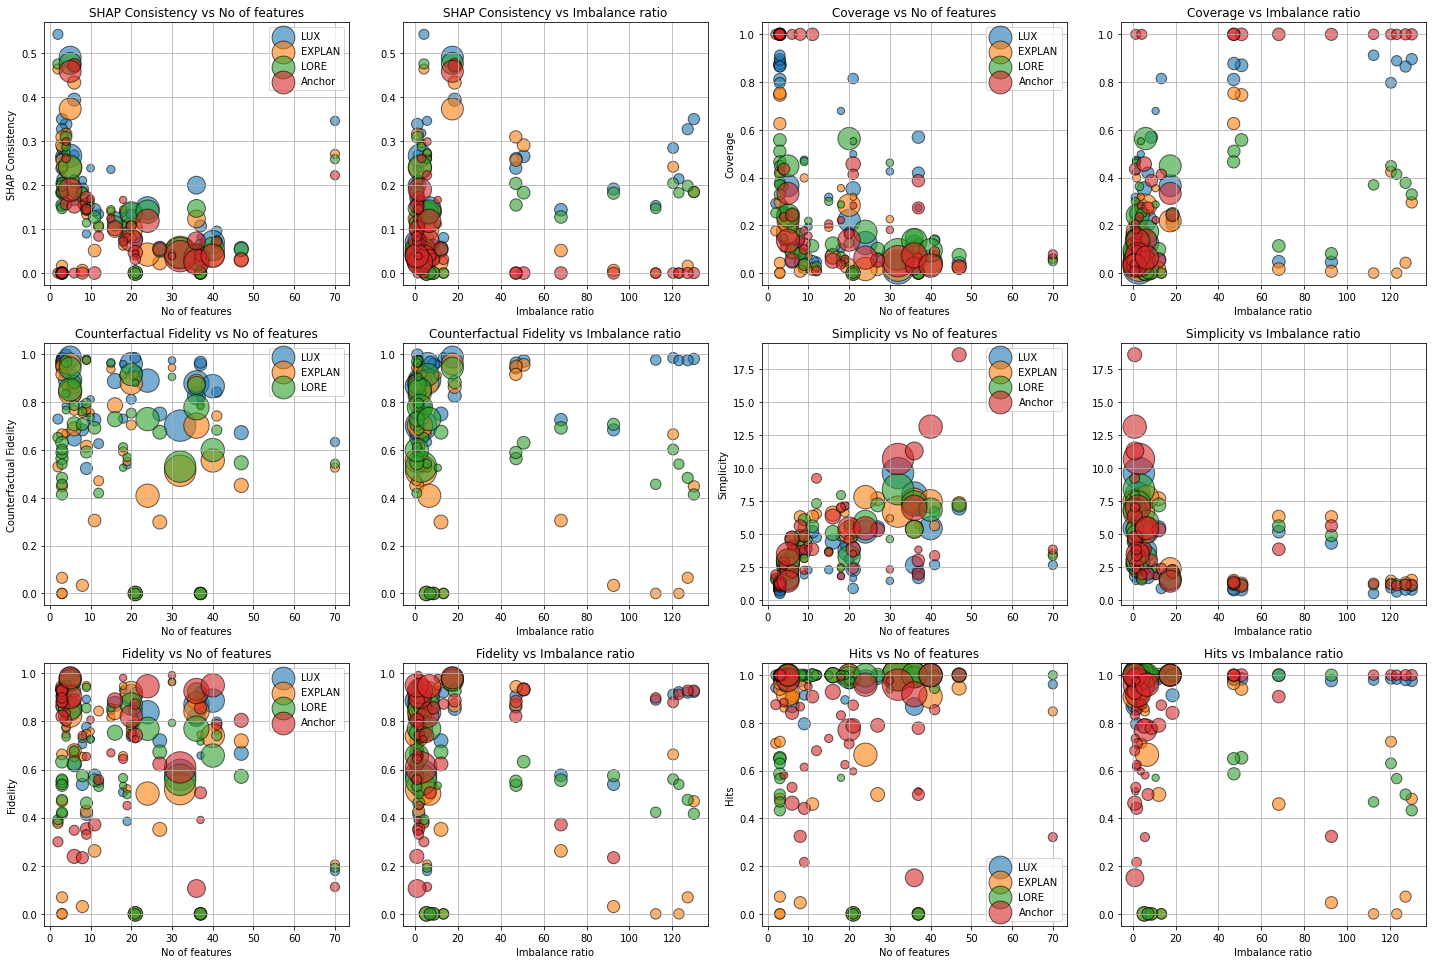

In [1490]:
import matplotlib.pyplot as plt
import pandas as pd
metrics = [ 'SHAP Consistency','Coverage','Counterfactual Fidelity','Simplicity','Fidelity','Hits']
results = [raw_shap.fillna(0),raw_cov.fillna(0),raw_cf.fillna(0),raw_sim,raw_fid.fillna(0),raw_fid.fillna(0),raw_hits.fillna(0)]
methods = [ ['LUX', 'EXPLAN', 'LORE','Anchor'], ['LUX', 'EXPLAN', 'LORE','Anchor'],['LUX', 'EXPLAN', 'LORE'],['LUX', 'EXPLAN', 'LORE', 'Anchor'],['LUX', 'EXPLAN', 'LORE', 'Anchor'], ['LUX', 'EXPLAN', 'LORE','Anchor']]


import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_metric_vs_features_and_imbalance(results, metrics, methods, ds_path='data_characteristics.csv', save_path='pix/metric_vs_features_imbalance.pdf'):
    ds = pd.read_csv(ds_path)
    ds.columns = ['dataset', 'No of instances', 'No of features', 'Imbalance ratio']

    # Each metric has two plots (one for each x-axis variable)
    plot_pairs = [('No of features', 'No of features'), ('Imbalance ratio', 'Imbalance ratio')]
    total_plots = len(metrics) * len(plot_pairs)
    
    n_cols = 4
    n_rows = math.ceil(total_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
    axes = axes.flatten()

    for i, (metric, result_df, method_list) in enumerate(zip(metrics, results, methods)):
        merged = result_df.merge(ds, on='dataset')
        mean_values = merged.groupby('dataset').mean().reset_index()
        mean_values['size'] = mean_values['No of features'] * mean_values['No of instances']

        for j, (x_var, x_label) in enumerate(plot_pairs):
            ax_idx = i * len(plot_pairs) + j
            ax = axes[ax_idx]

            for method in method_list:
                if method in mean_values.columns:
                    ax.scatter(
                        mean_values[x_var],
                        mean_values[method],
                        s=mean_values['No of instances'] / 10,
                        alpha=0.6,
                        label=method,
                        edgecolors='k'
                    )
            ax.set_xlabel(x_label)
            ax.set_ylabel(metric if j == 0 else "")
            ax.set_title(f'{metric} vs {x_label}')
            ax.grid(True)
            if j == 0:
                ax.legend()

    # Hide unused axes
    for ax in axes[total_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

plot_metric_vs_features_and_imbalance(
    results=[raw_shap.fillna(0), raw_cov.fillna(0), raw_cf.fillna(0), raw_sim, raw_fid.fillna(0), raw_hits.fillna(0)],
    metrics=['SHAP Consistency', 'Coverage', 'Counterfactual Fidelity', 'Simplicity', 'Fidelity', 'Hits'],
    methods=methods
)

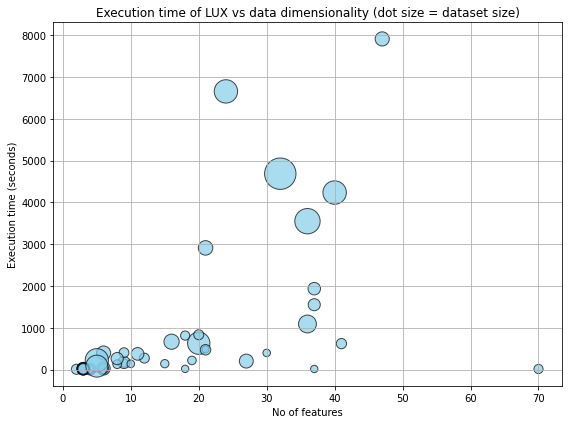

In [1506]:
ds = pd.read_csv('data_characteristics.csv')
ds.columns = ['dataset', 'No of instances', 'No of features', 'Imbalance ratio']

rawmean = raw_times.merge(ds, on='dataset').groupby('dataset').mean()
rawmean['size'] = rawmean['No of features']*rawmean['No of instances']
plt.figure(figsize=(8, 6))
plt.scatter(
    rawmean['No of features'],
    rawmean['LUX'],
    s=rawmean['No of instances'] / 10,  # adjust scaling factor if dots are too big/small
    alpha=0.7,
    color='skyblue',
    edgecolors='k'
)

plt.xlabel('No of features')
plt.ylabel('Execution time (seconds)')
plt.title('Execution time of LUX vs data dimensionality (dot size = dataset size)')
plt.grid(True)
plt.tight_layout()
plt.savefig('./pix/time-size-realtion.pdf', format='pdf',bbox_inches='tight')
plt.show()

## Spiderplot

In [1492]:
def area(method, angle):
    a = 0
    for i in range(0,len(method)-1):
        a += 0.5*method[i]*method[i+1]*np.sin(angle)
    return a

In [1493]:
angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)



In [1494]:
def reorder_list(lst, order):
    return [lst[i - 1] for i in order]


# New order
new_order = [1, 2,3, 4, 5, 6, 7, 8]

# Apply reordering
subjects = reorder_list(subjects, new_order)
lux = reorder_list(lux, new_order)
lore = reorder_list(lore, new_order)
explan = reorder_list(explan, new_order)
anchor = reorder_list(anchor, new_order)

In [1495]:
angles=np.concatenate((angles,[angles[0]]))
subjects.append(subjects[0])
lux.append(lux[0])
lore.append(lore[0])
explan.append(explan[0])
anchor.append(anchor[0])

In [1496]:
objects = ['Lux','Lore','Explan','Anchor']
#palette = dict(zip(objects,sns.color_palette('Set2',len(objects))))
palette=     {
        'Lux': 'skyblue',
        'Lore': 'lightgreen',
        'Explan': 'gold',
        'Anchor': 'lightcoral'
    }

## Barplot comparing models

In [1497]:
angle = 2*np.pi/(len(subjects)-2)
alux = sum(lux[0:-1])#area(lux, angle)
alore = sum(lore[0:-1])#area(lore, angle)
aexplan = sum(explan[0:-1])#area(explan, angle)
aanchor = sum(anchor[0:-1])#area(anchor, angle)

# lux_rf=lux
# lore_rf=lore
# explan_rf=explan
# anchor_rf=anchor

In [1498]:
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.pyplot as plt
import numpy as np

def plot_subject_scores_comparison(
    subjects,
    lux, lore, explan, anchor,
    lux_rf, lore_rf, explan_rf, anchor_rf,
    title="Metric-wise Score Comparison"
):
    """
    Plot per-subject scores for each method comparing pure and _rf versions (side by side).
    """
    # Truncate data
    subject_labels = subjects[0:-1]
    lux, lore, explan, anchor = lux[0:-1], lore[0:-1], explan[0:-1], anchor[0:-1]
    lux_rf, lore_rf, explan_rf, anchor_rf = lux_rf[0:-1], lore_rf[0:-1], explan_rf[0:-1], anchor_rf[0:-1]

    n_subjects = len(subject_labels)
    x = np.arange(n_subjects)
    width = 0.1  # narrower bars since there are 8

    fig, ax = plt.subplots(figsize=(max(10, n_subjects * 0.7), 6))

    # Plot bars side by side
    ax.bar(x - 3.5 * width, lux, width, label='(MLP) LUX', color='skyblue')
    ax.bar(x - 2.5 * width, lux_rf, width, label='(GXB) LUX', color='blue')

    ax.bar(x - 1.5 * width, lore, width, label='(MLP) LORE', color='lightgreen')
    ax.bar(x - 0.5 * width, lore_rf, width, label='(GXB) LORE', color='green')

    ax.bar(x + 0.5 * width, explan, width, label='(MLP) EXPLAN', color='gold')
    ax.bar(x + 1.5 * width, explan_rf, width, label='(GXB) EXPLAN', color='orange')

    ax.bar(x + 2.5 * width, anchor, width, label='(MLP) Anchor', color='lightcoral')
    ax.bar(x + 3.5 * width, anchor_rf, width, label='(GXB) Anchor', color='red')

    ax.set_title(title)
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(subject_labels, rotation=45, ha='right')
    ax.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    
# plot_subject_scores_comparison(
#     subjects,
#     lux, lore, explan, anchor,
#     lux_rf, lore_rf, explan_rf, anchor_rf,
# )

In [1499]:
subjects

['Fidelity',
 'Simplicity',
 'Counterfactual Fidelity',
 'Coverage',
 'Stability',
 'Representativeness',
 'SHAP Consistency',
 'Hits',
 'Fidelity']

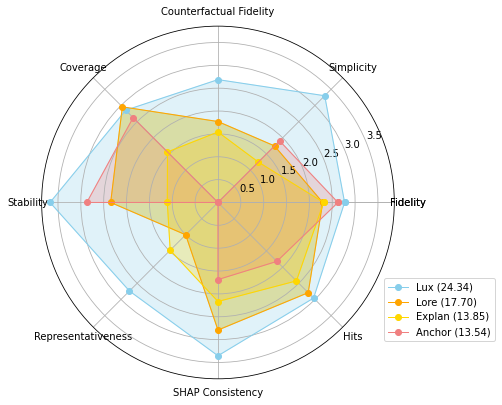

In [1500]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)
#Alice Plot
ax.plot(angles,lux, 'o-', color=palette['Lux'], linewidth=1, label=f'Lux ({alux:.2f})')
ax.fill(angles, lux, alpha=0.25, color=palette['Lux'])
#Bob Plot
ax.plot(angles,lore, 'o-', color='orange', linewidth=1, label=f'Lore ({alore:.2f})')
ax.fill(angles, lore, alpha=0.25, color=palette['Lore'])

ax.plot(angles,explan, 'o-', color=palette['Explan'], linewidth=1, label=f'Explan ({aexplan:.2f})')
ax.fill(angles, explan, alpha=0.25, color=palette['Explan'])

ax.plot(angles,anchor, 'o-', color=palette['Anchor'], linewidth=1, label=f'Anchor ({aanchor:.2f})')
ax.fill(angles, anchor, alpha=0.25, color=palette['Anchor'])


ax.fill(angles, lore, alpha=0.25, color='orange')
ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='best', bbox_to_anchor=(0.9, 0.0, 0.4, 0.3))
#plt.title('Scores of various metrics. The larger the area, the better.')
plt.savefig('./pix/spiderplotx.pdf', format='pdf',bbox_inches='tight')
#plt.savefig('./pix/spiderplotx.svg', format='svg',bbox_inches='tight')
plt.show()

## Total

In [1501]:
ranks=True
if ranks:
    avranks_fid=rankdata(aggfid, axis=1)
    avranks_sim=rankdata(aggsim, axis=1)
    avranks_sim= np.apply_along_axis(lambda x: abs(x -max(x))+min(x),axis=1,arr=avranks_sim)
    
    avranks_cf=rankdata(aggcf, axis=1)
    avranks_cov=rankdata(aggcov, axis=1)
    avranks_stab=rankdata(aggstab, axis=1)
    avranks_phantom=rankdata(aggphantom, axis=1)
    avranks_phantom= np.apply_along_axis(lambda x: abs(x -max(x))+min(x),axis=1,arr=avranks_phantom)
    #avranks_consist=rankdata(aggconsist, axis=1)
    avranks_consist_shap=rankdata(aggconsist_shap, axis=1)
    avranks_stabr=rankdata(aggstabr, axis=1)
    avranks_hits=rankdata(agghits, axis=1)


In [1502]:
allc = ['LUX','EXPLAN','LORE','Anchor']

avranks_fiddf = pd.DataFrame(avranks_fid,index=['Fidelity']*avranks_fid.shape[0],columns=[allc[i] for i in range(avranks_fid.shape[1])])
avranks_simdf = pd.DataFrame(avranks_sim,index=['Simplicity']*avranks_sim.shape[0],columns=[allc[i] for i in range(avranks_sim.shape[1])])
avranks_cfdf = pd.DataFrame(avranks_cf,index=['Counterfactual Fidelity']*avranks_cf.shape[0],columns=[allc[i] for i in range(avranks_cf.shape[1])])
avranks_covdf = pd.DataFrame(avranks_cov, index=['Coverage']*avranks_sim.shape[0],columns=[allc[i] for i in range(avranks_cov.shape[1])])
avranks_stabdf = pd.DataFrame(avranks_stab, index=['Stability']*avranks_stab.shape[0],columns=[allc[i] for i in range(avranks_stab.shape[1])])
avranks_phantomdf = pd.DataFrame(avranks_phantom, index=['Representativeness']*avranks_phantom.shape[0],columns=[allc[i] for i in range(avranks_phantom.shape[1])])
#avranks_consistdf = pd.DataFrame(avranks_consist, index=['Consistency']*avranks_consist.shape[0],columns=[allc[i] for i in range(avranks_consist.shape[1])])
avranks_consistdf_shap = pd.DataFrame(avranks_consist_shap, index=['Shap Consistency']*avranks_consist_shap.shape[0],columns=[allc[i] for i in range(avranks_consist_shap.shape[1])])
avranks_stabrdf = pd.DataFrame(avranks_stabr, index=['Stability Realdata']*avranks_stabr.shape[0],columns=[allc[i] for i in range(avranks_stabr.shape[1])])
avranks_hits = pd.DataFrame(avranks_hits, index=['Hits']*avranks_hits.shape[0],columns=[allc[i] for i in range(avranks_hits.shape[1])])



aggregated = pd.concat([
    avranks_fiddf, 
    avranks_simdf, 
    avranks_cfdf, 
    avranks_covdf, 
    avranks_stabdf, 
    avranks_phantomdf, 
    #avranks_consistdf, 
    avranks_consistdf_shap, 
    avranks_hits, 
    #avranks_stabrdf
], axis=0).rename_axis('metric').fillna(0).groupby('metric').mean()


aggregated_std = pd.concat([
    avranks_fiddf, 
    avranks_simdf, 
    avranks_cfdf, 
    avranks_covdf, 
    avranks_stabdf, 
    avranks_phantomdf, 
   # avranks_consistdf, 
    avranks_consistdf_shap, 
    avranks_hits, 
    #avranks_stabrdf
], axis=0).rename_axis('metric').fillna(0).groupby('metric').std()

Reject null-hypothesis 3.072466986396876 < 13.650000000000006
Number of freedom degrees: 3 x 21
cd=1.658303025312322


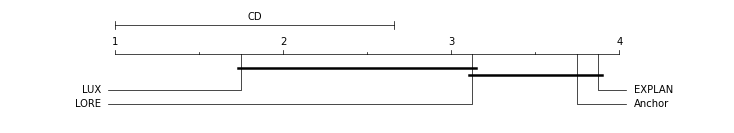

In [1503]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),aggregated.shape[1])#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_total.pdf')

In [1504]:
print(to_latex(aggregated, aggregated_std, index_name='metric'))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
metric & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
Counterfactual Fidelity & \textbf{2.69 $\pm$ 0.69} & 1.54 $\pm$ 0.62 & 1.77 $\pm$ 0.66 & 0.00 $\pm$ 0.00\\ \hline
Coverage & 2.85 $\pm$ 0.87 & 1.56 $\pm$ 0.68 & \textbf{2.96 $\pm$ 1.01} & 2.62 $\pm$ 1.27\\ \hline
Fidelity & \textbf{2.77 $\pm$ 0.93} & 2.31 $\pm$ 1.12 & 2.29 $\pm$ 1.16 & 2.62 $\pm$ 1.20\\ \hline
Hits & \textbf{2.96 $\pm$ 0.60} & 2.43 $\pm$ 0.96 & 2.79 $\pm$ 1.02 & 1.82 $\pm$ 1.15\\ \hline
Representativeness & \textbf{3.00 $\pm$ 0.00} & 1.74 $\pm$ 0.44 & 1.26 $\pm$ 0.44 & 0.00 $\pm$ 0.00\\ \hline
Shap Consistency & \textbf{3.35 $\pm$ 0.96} & 2.17 $\pm$ 1.04 & 2.79 $\pm$ 0.77 & 1.69 $\pm$ 0.95\\ \hline
Simplicity & \textbf{3.75 $\pm$ 0.60} & 1.70 $\pm$ 0.78 & 2.20 $\pm$ 0.79 & 2.35 $\pm$ 1.06\\ \hline
Stability & \textbf{3.67 $\pm$ 0.66} & 1.11 $\pm$ 0.48 & 2.35 $\pm$ 0.48 & 2.87 $\pm$ 0.80\\ \hline
\end{tabularx}
\end{table}
None


In [1505]:
aggregated

,LUX,EXPLAN,LORE,Anchor
metric,,,,
Counterfactual Fidelity,2.687500,1.541667,1.770833,0.000000
Coverage,2.854167,1.562500,2.958333,2.625000
Fidelity,2.770833,2.312500,2.291667,2.625000
Hits,2.958333,2.427083,2.791667,1.822917
Representativeness,3.000000,1.739130,1.260870,0.000000
Shap Consistency,3.354167,2.166667,2.791667,1.687500
Simplicity,3.750000,1.697917,2.197917,2.354167
Stability,3.673913,1.108696,2.347826,2.869565
